In [11]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import image
import numpy
from tqdm import tqdm
from utils import * 


rgb = image.imread("euler.jpg")
lines, columns = rgb.shape[:-1]

def rgb2gray(rgb):
    return numpy.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))

#Sample data according to image
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lines, columns = grey.shape
num_samples = 30000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([((categorical_samples%columns + torch.rand(num_samples))/columns).unsqueeze(-1),((1-(categorical_samples//columns + torch.rand(num_samples))/lines)).unsqueeze(-1)], dim = -1)

mean = torch.mean(target_samples, dim = 0)
cov = torch.cov(target_samples.T)
instrumental = torch.distributions.MultivariateNormal(mean, (cov + cov.T)/2)
proposed_samples = instrumental.sample([num_samples])

In [4]:
from classifiers import * 
binary_classif = BinaryClassifier(proposed_samples, target_samples,[128,128,128])
binary_classif.train(100,10000,lr = 1e-3, weight_decay = 0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it, loss = 1.281; device = cpu]


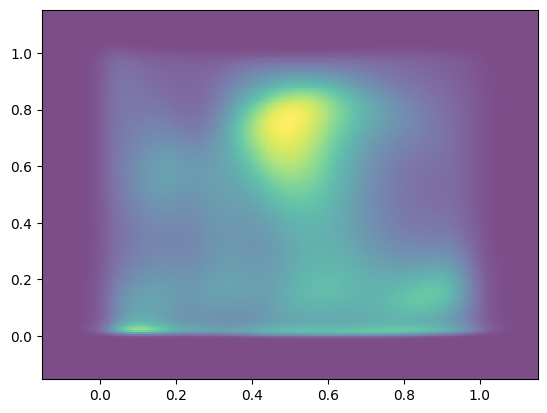

In [9]:
plot_2d_function(lambda x: torch.exp(binary_classif.logit_r(x).squeeze(-1) + instrumental.log_prob(x)), bins = (lines, columns), range =[[-0.15,1.15],[-0.15,1.15]])

In [10]:
binary_classif.train(100,10000,lr = 5e-4, weight_decay = 5e-6)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:02:48<00:00, 721.68s/it, loss = 1.244822; device = cpu]


In [32]:
torch.save(binary_classif, 'model.sav')